In [414]:
import os
import datetime
import math as m
from collections import defaultdict
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
from python_speech_features import mfcc
import librosa
from librosa.feature import melspectrogram
import librosa.display
from IPython.display import Audio

import pickle

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Dropout, SpatialDropout2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


from buildfeats import build_rand_feat, check_data
# from model import get_conv_model
from cfg import Config


In [15]:
config = Config(feature_type='mels', n_mels=60)
config.step = int(16000 / 2.5)

In [16]:
##experimenting just on the 'curated' train set
df = pd.read_csv('data/train/roadsound_labels.csv', index_col=0)
df.set_index('fname', inplace=True)
for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate
df.shape

(297, 2)

In [17]:
df = df[df.length > config.step/rate]
df.shape

(294, 2)

In [18]:
classes = list(np.unique(df.labels))
class_dist = df.groupby(['labels'])['length'].mean()
n_samples = 2 * int(df['length'].sum() / 0.1) # 40 * total length of audio
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

In [19]:
df, test_df, _ , _ = train_test_split(df, df.labels)

In [115]:
def rand_feats_exper(df, split): 
    X = []
    y = []
    n_samples = 2 * int(df['length'].sum() / 0.1) # starting small
    _min, _max = float('inf'), -float('inf')

    print('Building features for '+split)
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(classes, p=prob_dist)
        file = np.random.choice(df[df.labels == rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        rand_index = np.random.randint(0, wav.shape[0] - config.step)
        sample = wav[rand_index:rand_index + config.step]
        if config.feature_type == 'mels':
            X_sample = melspectrogram(sample, rate, n_mels=60,
                                        n_fft=1028)
            X_sample = librosa.power_to_db(X_sample)
        if config.feature_type == 'raw':
            X_sample = sample
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(rand_class))
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    # X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) ## not needed for raw signal
    y = to_categorical(y)
    return X, y

In [116]:
X_train, y_train = rand_feats_exper(df, 'train')

Building features for train


In [117]:
X_test, y_test = rand_feats_exper(test_df, 'test')

Building features for test


In [118]:
print('X shape: ',X.shape)
print('y shape: ', y.shape)

X shape:  (1000, 60, 13)
y shape:  (1000, 5)


In [119]:
config.mode

'conv'

In [120]:
#flatten (for autoencode)
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

In [121]:
X_test.shape

(12912, 780)

In [122]:
y_flat = np.argmax(y, axis=1)

In [123]:
class_weight = compute_class_weight('balanced',
                                    np.unique(y_flat),
                                    y_flat)

In [124]:
class_weight

array([2.3255814 , 0.91743119, 0.77821012, 0.5952381 , 1.94174757])

In [125]:
shp = (X_train.shape[1], )
shp

(780,)

In [126]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu',
                    strides=(1,1), padding='same', input_shape=input_shape_1d))    
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1,1),padding='same')) 
    # model.add(SpatialDropout2D(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1),padding='same'))
    # model.add(Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    # model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
    return model

In [131]:
def get_ae_model():
    model = Sequential()
    model.add(Dense(16,  activation='relu', input_shape=shp))
    model.add(Dense(32,  activation='relu'))
    model.add(Dense(64,  activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128,  activation='relu'))
    model.add(Dense(256,  activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512,  activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5,    activation='linear', name="bottleneck"))
    model.add(Dense(512,  activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,  activation='relu'))
    model.add(Dense(128,  activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,  activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(shp[0],  activation='linear'))
    model.compile(loss='mean_squared_error', optimizer = 'sgd', metrics=['accuracy'])
    return model

In [149]:
aemodel = get_ae_model()

In [150]:
aemodel.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 16)                12496     
_________________________________________________________________
dense_47 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_48 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_50 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

In [151]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=2, 
                        batch_size=512, write_graph=True, 
                        write_grads=True, write_images=True)

In [152]:
history = aemodel.fit(X_train.astype(float), X_train.astype(float),
                     batch_size=512,
                     epochs=1000,
                     validation_data=(X_test.astype(float), X_test.astype(float)),
                     class_weight=class_weight,
                     callbacks=[tensorboard])

Train on 40736 samples, validate on 12912 samples
Epoch 1/1000
40736/40736 [==============================] - 4s 99us/sample - loss: 0.3381 - accuracy: 0.0011 - val_loss: 0.3469 - val_accuracy: 0.0017
Epoch 2/1000
40736/40736 [==============================] - 4s 88us/sample - loss: 0.3367 - accuracy: 0.0016 - val_loss: 0.3455 - val_accuracy: 0.0016
Epoch 3/1000
40736/40736 [==============================] - 3s 79us/sample - loss: 0.3353 - accuracy: 0.0020 - val_loss: 0.3441 - val_accuracy: 0.0025
Epoch 4/1000
40736/40736 [==============================] - 4s 99us/sample - loss: 0.3339 - accuracy: 0.0024 - val_loss: 0.3426 - val_accuracy: 0.0025
Epoch 5/1000
40736/40736 [==============================] - 3s 69us/sample - loss: 0.3325 - accuracy: 0.0027 - val_loss: 0.3412 - val_accuracy: 0.0025
Epoch 6/1000
40736/40736 [==============================] - 3s 79us/sample - loss: 0.3311 - accuracy: 0.0022 - val_loss: 0.3398 - val_accuracy: 0.0026
Epoch 7/1000
40736/40736 [==================

40736/40736 [==============================] - 3s 74us/sample - loss: 0.2346 - accuracy: 0.0025 - val_loss: 0.2317 - val_accuracy: 0.0023
Epoch 55/1000
40736/40736 [==============================] - 3s 77us/sample - loss: 0.2302 - accuracy: 0.0021 - val_loss: 0.2262 - val_accuracy: 0.0023
Epoch 56/1000
40736/40736 [==============================] - 3s 74us/sample - loss: 0.2257 - accuracy: 0.0022 - val_loss: 0.2202 - val_accuracy: 0.0023
Epoch 57/1000
40736/40736 [==============================] - 3s 68us/sample - loss: 0.2207 - accuracy: 0.0023 - val_loss: 0.2139 - val_accuracy: 0.0023
Epoch 58/1000
40736/40736 [==============================] - 3s 68us/sample - loss: 0.2156 - accuracy: 0.0021 - val_loss: 0.2072 - val_accuracy: 0.0023
Epoch 59/1000
40736/40736 [==============================] - 3s 69us/sample - loss: 0.2102 - accuracy: 0.0023 - val_loss: 0.2001 - val_accuracy: 0.0023
Epoch 60/1000
40736/40736 [==============================] - 3s 68us/sample - loss: 0.2044 - accuracy:

Epoch 108/1000
40736/40736 [==============================] - 3s 71us/sample - loss: 0.0700 - accuracy: 0.0030 - val_loss: 0.0308 - val_accuracy: 0.0023
Epoch 109/1000
40736/40736 [==============================] - 3s 71us/sample - loss: 0.0694 - accuracy: 0.0037 - val_loss: 0.0304 - val_accuracy: 0.0023
Epoch 110/1000
40736/40736 [==============================] - 4s 90us/sample - loss: 0.0690 - accuracy: 0.0031 - val_loss: 0.0303 - val_accuracy: 0.0023
Epoch 111/1000
40736/40736 [==============================] - 4s 101us/sample - loss: 0.0681 - accuracy: 0.0030 - val_loss: 0.0298 - val_accuracy: 0.0023
Epoch 112/1000
40736/40736 [==============================] - 5s 118us/sample - loss: 0.0675 - accuracy: 0.0030 - val_loss: 0.0295 - val_accuracy: 0.0023
Epoch 113/1000
40736/40736 [==============================] - 4s 87us/sample - loss: 0.0671 - accuracy: 0.0027 - val_loss: 0.0292 - val_accuracy: 0.0023
Epoch 114/1000
40736/40736 [==============================] - 3s 74us/sample - l

40736/40736 [==============================] - 3s 71us/sample - loss: 0.0501 - accuracy: 0.0038 - val_loss: 0.0230 - val_accuracy: 0.0191
Epoch 162/1000
40736/40736 [==============================] - 3s 68us/sample - loss: 0.0497 - accuracy: 0.0044 - val_loss: 0.0233 - val_accuracy: 0.0191
Epoch 163/1000
40736/40736 [==============================] - 3s 80us/sample - loss: 0.0498 - accuracy: 0.0037 - val_loss: 0.0231 - val_accuracy: 0.0191
Epoch 164/1000
40736/40736 [==============================] - 3s 74us/sample - loss: 0.0491 - accuracy: 0.0036 - val_loss: 0.0227 - val_accuracy: 0.0191
Epoch 165/1000
40736/40736 [==============================] - 3s 71us/sample - loss: 0.0494 - accuracy: 0.0033 - val_loss: 0.0227 - val_accuracy: 0.0191
Epoch 166/1000
40736/40736 [==============================] - 3s 70us/sample - loss: 0.0490 - accuracy: 0.0035 - val_loss: 0.0230 - val_accuracy: 0.0191
Epoch 167/1000
40736/40736 [==============================] - 3s 79us/sample - loss: 0.0485 - acc

40736/40736 [==============================] - 3s 72us/sample - loss: 0.0406 - accuracy: 0.0043 - val_loss: 0.0229 - val_accuracy: 0.0170
Epoch 215/1000
40736/40736 [==============================] - 3s 71us/sample - loss: 0.0404 - accuracy: 0.0037 - val_loss: 0.0234 - val_accuracy: 0.0170
Epoch 216/1000
40736/40736 [==============================] - 3s 68us/sample - loss: 0.0405 - accuracy: 0.0039 - val_loss: 0.0233 - val_accuracy: 0.0170
Epoch 217/1000
40736/40736 [==============================] - 3s 70us/sample - loss: 0.0404 - accuracy: 0.0046 - val_loss: 0.0233 - val_accuracy: 0.0170
Epoch 218/1000
40736/40736 [==============================] - 3s 70us/sample - loss: 0.0402 - accuracy: 0.0043 - val_loss: 0.0235 - val_accuracy: 0.0167
Epoch 219/1000
40736/40736 [==============================] - 3s 71us/sample - loss: 0.0398 - accuracy: 0.0043 - val_loss: 0.0234 - val_accuracy: 0.0167
Epoch 220/1000
40736/40736 [==============================] - 3s 72us/sample - loss: 0.0398 - acc

40736/40736 [==============================] - 4s 104us/sample - loss: 0.0349 - accuracy: 0.0048 - val_loss: 0.0256 - val_accuracy: 0.0136
Epoch 268/1000
40736/40736 [==============================] - 4s 108us/sample - loss: 0.0351 - accuracy: 0.0048 - val_loss: 0.0260 - val_accuracy: 0.0132
Epoch 269/1000
40736/40736 [==============================] - 4s 97us/sample - loss: 0.0346 - accuracy: 0.0041 - val_loss: 0.0258 - val_accuracy: 0.0133
Epoch 270/1000
40736/40736 [==============================] - 3s 84us/sample - loss: 0.0347 - accuracy: 0.0047 - val_loss: 0.0263 - val_accuracy: 0.0127
Epoch 271/1000
40736/40736 [==============================] - 4s 96us/sample - loss: 0.0347 - accuracy: 0.0041 - val_loss: 0.0257 - val_accuracy: 0.0132
Epoch 272/1000
40736/40736 [==============================] - 3s 79us/sample - loss: 0.0348 - accuracy: 0.0041 - val_loss: 0.0262 - val_accuracy: 0.0131
Epoch 273/1000
40736/40736 [==============================] - 4s 91us/sample - loss: 0.0346 - a

40736/40736 [==============================] - 4s 90us/sample - loss: 0.0311 - accuracy: 0.0044 - val_loss: 0.0292 - val_accuracy: 0.0131
Epoch 321/1000
40736/40736 [==============================] - 4s 92us/sample - loss: 0.0309 - accuracy: 0.0042 - val_loss: 0.0304 - val_accuracy: 0.0134
Epoch 322/1000
40736/40736 [==============================] - 3s 75us/sample - loss: 0.0313 - accuracy: 0.0048 - val_loss: 0.0303 - val_accuracy: 0.0132
Epoch 323/1000
40736/40736 [==============================] - 3s 79us/sample - loss: 0.0308 - accuracy: 0.0047 - val_loss: 0.0307 - val_accuracy: 0.0131
Epoch 324/1000
40736/40736 [==============================] - 4s 87us/sample - loss: 0.0308 - accuracy: 0.0052 - val_loss: 0.0298 - val_accuracy: 0.0125
Epoch 325/1000
40736/40736 [==============================] - 4s 97us/sample - loss: 0.0307 - accuracy: 0.0041 - val_loss: 0.0299 - val_accuracy: 0.0128
Epoch 326/1000
40736/40736 [==============================] - 3s 85us/sample - loss: 0.0307 - acc

40736/40736 [==============================] - 4s 96us/sample - loss: 0.0283 - accuracy: 0.0042 - val_loss: 0.0331 - val_accuracy: 0.0135
Epoch 374/1000
40736/40736 [==============================] - 3s 72us/sample - loss: 0.0282 - accuracy: 0.0044 - val_loss: 0.0319 - val_accuracy: 0.0133
Epoch 375/1000
40736/40736 [==============================] - 3s 74us/sample - loss: 0.0284 - accuracy: 0.0047 - val_loss: 0.0330 - val_accuracy: 0.0134
Epoch 376/1000
40736/40736 [==============================] - 4s 87us/sample - loss: 0.0284 - accuracy: 0.0053 - val_loss: 0.0327 - val_accuracy: 0.0132
Epoch 377/1000
40736/40736 [==============================] - 4s 107us/sample - loss: 0.0281 - accuracy: 0.0045 - val_loss: 0.0328 - val_accuracy: 0.0136
Epoch 378/1000
40736/40736 [==============================] - 4s 94us/sample - loss: 0.0281 - accuracy: 0.0050 - val_loss: 0.0326 - val_accuracy: 0.0135
Epoch 379/1000
40736/40736 [==============================] - 3s 81us/sample - loss: 0.0283 - ac

40736/40736 [==============================] - 3s 84us/sample - loss: 0.0263 - accuracy: 0.0052 - val_loss: 0.0337 - val_accuracy: 0.0084
Epoch 427/1000
40736/40736 [==============================] - 5s 120us/sample - loss: 0.0262 - accuracy: 0.0052 - val_loss: 0.0347 - val_accuracy: 0.0088
Epoch 428/1000
40736/40736 [==============================] - 4s 109us/sample - loss: 0.0264 - accuracy: 0.0052 - val_loss: 0.0343 - val_accuracy: 0.0087
Epoch 429/1000
40736/40736 [==============================] - 6s 158us/sample - loss: 0.0262 - accuracy: 0.0051 - val_loss: 0.0342 - val_accuracy: 0.0085
Epoch 430/1000
40736/40736 [==============================] - 5s 119us/sample - loss: 0.0261 - accuracy: 0.0055 - val_loss: 0.0350 - val_accuracy: 0.0086
Epoch 431/1000
40736/40736 [==============================] - 4s 102us/sample - loss: 0.0263 - accuracy: 0.0050 - val_loss: 0.0342 - val_accuracy: 0.0089
Epoch 432/1000
40736/40736 [==============================] - 4s 87us/sample - loss: 0.0262 

40736/40736 [==============================] - 3s 83us/sample - loss: 0.0248 - accuracy: 0.0059 - val_loss: 0.0345 - val_accuracy: 0.0079
Epoch 480/1000
40736/40736 [==============================] - 3s 72us/sample - loss: 0.0248 - accuracy: 0.0051 - val_loss: 0.0350 - val_accuracy: 0.0071
Epoch 481/1000
40736/40736 [==============================] - 3s 74us/sample - loss: 0.0247 - accuracy: 0.0055 - val_loss: 0.0342 - val_accuracy: 0.0075
Epoch 482/1000
40736/40736 [==============================] - 3s 74us/sample - loss: 0.0246 - accuracy: 0.0053 - val_loss: 0.0340 - val_accuracy: 0.0077
Epoch 483/1000
40736/40736 [==============================] - 3s 75us/sample - loss: 0.0247 - accuracy: 0.0051 - val_loss: 0.0340 - val_accuracy: 0.0077
Epoch 484/1000
40736/40736 [==============================] - 3s 73us/sample - loss: 0.0246 - accuracy: 0.0056 - val_loss: 0.0343 - val_accuracy: 0.0079
Epoch 485/1000
40736/40736 [==============================] - 3s 81us/sample - loss: 0.0247 - acc

40736/40736 [==============================] - 4s 92us/sample - loss: 0.0235 - accuracy: 0.0060 - val_loss: 0.0335 - val_accuracy: 0.0084
Epoch 533/1000
40736/40736 [==============================] - 4s 109us/sample - loss: 0.0234 - accuracy: 0.0054 - val_loss: 0.0334 - val_accuracy: 0.0084
Epoch 534/1000
40736/40736 [==============================] - 4s 104us/sample - loss: 0.0237 - accuracy: 0.0054 - val_loss: 0.0345 - val_accuracy: 0.0086
Epoch 535/1000
40736/40736 [==============================] - 3s 86us/sample - loss: 0.0236 - accuracy: 0.0051 - val_loss: 0.0327 - val_accuracy: 0.0086
Epoch 536/1000
40736/40736 [==============================] - 4s 91us/sample - loss: 0.0233 - accuracy: 0.0053 - val_loss: 0.0330 - val_accuracy: 0.0088
Epoch 537/1000
40736/40736 [==============================] - 3s 85us/sample - loss: 0.0235 - accuracy: 0.0056 - val_loss: 0.0327 - val_accuracy: 0.0091
Epoch 538/1000
40736/40736 [==============================] - 4s 100us/sample - loss: 0.0236 - 

40736/40736 [==============================] - 3s 78us/sample - loss: 0.0227 - accuracy: 0.0051 - val_loss: 0.0317 - val_accuracy: 0.0091
Epoch 586/1000
40736/40736 [==============================] - 3s 77us/sample - loss: 0.0228 - accuracy: 0.0060 - val_loss: 0.0326 - val_accuracy: 0.0090
Epoch 587/1000
40736/40736 [==============================] - 4s 88us/sample - loss: 0.0226 - accuracy: 0.0048 - val_loss: 0.0323 - val_accuracy: 0.0092
Epoch 588/1000
40736/40736 [==============================] - 4s 89us/sample - loss: 0.0225 - accuracy: 0.0057 - val_loss: 0.0317 - val_accuracy: 0.0092
Epoch 589/1000
40736/40736 [==============================] - 3s 86us/sample - loss: 0.0225 - accuracy: 0.0051 - val_loss: 0.0319 - val_accuracy: 0.0090
Epoch 590/1000
40736/40736 [==============================] - 5s 112us/sample - loss: 0.0225 - accuracy: 0.0056 - val_loss: 0.0321 - val_accuracy: 0.0091
Epoch 591/1000
40736/40736 [==============================] - 5s 112us/sample - loss: 0.0225 - a

40736/40736 [==============================] - 4s 91us/sample - loss: 0.0218 - accuracy: 0.0054 - val_loss: 0.0313 - val_accuracy: 0.0094
Epoch 639/1000
40736/40736 [==============================] - 4s 88us/sample - loss: 0.0219 - accuracy: 0.0056 - val_loss: 0.0312 - val_accuracy: 0.0092
Epoch 640/1000
40736/40736 [==============================] - 3s 85us/sample - loss: 0.0216 - accuracy: 0.0056 - val_loss: 0.0309 - val_accuracy: 0.0093
Epoch 641/1000
40736/40736 [==============================] - 4s 93us/sample - loss: 0.0216 - accuracy: 0.0061 - val_loss: 0.0305 - val_accuracy: 0.0094
Epoch 642/1000
40736/40736 [==============================] - 4s 92us/sample - loss: 0.0217 - accuracy: 0.0052 - val_loss: 0.0302 - val_accuracy: 0.0094
Epoch 643/1000
40736/40736 [==============================] - 3s 85us/sample - loss: 0.0216 - accuracy: 0.0057 - val_loss: 0.0304 - val_accuracy: 0.0093
Epoch 644/1000
40736/40736 [==============================] - 3s 82us/sample - loss: 0.0218 - acc

40736/40736 [==============================] - 3s 74us/sample - loss: 0.0208 - accuracy: 0.0061 - val_loss: 0.0298 - val_accuracy: 0.0094
Epoch 692/1000
40736/40736 [==============================] - 3s 75us/sample - loss: 0.0209 - accuracy: 0.0059 - val_loss: 0.0299 - val_accuracy: 0.0095
Epoch 693/1000
40736/40736 [==============================] - 3s 81us/sample - loss: 0.0208 - accuracy: 0.0056 - val_loss: 0.0293 - val_accuracy: 0.0094
Epoch 694/1000
40736/40736 [==============================] - 3s 77us/sample - loss: 0.0210 - accuracy: 0.0054 - val_loss: 0.0293 - val_accuracy: 0.0095
Epoch 695/1000
40736/40736 [==============================] - 3s 80us/sample - loss: 0.0211 - accuracy: 0.0059 - val_loss: 0.0303 - val_accuracy: 0.0094
Epoch 696/1000
40736/40736 [==============================] - 3s 71us/sample - loss: 0.0210 - accuracy: 0.0058 - val_loss: 0.0302 - val_accuracy: 0.0095
Epoch 697/1000
40736/40736 [==============================] - 3s 78us/sample - loss: 0.0209 - acc

40736/40736 [==============================] - 3s 72us/sample - loss: 0.0205 - accuracy: 0.0056 - val_loss: 0.0293 - val_accuracy: 0.0094
Epoch 745/1000
40736/40736 [==============================] - 3s 76us/sample - loss: 0.0204 - accuracy: 0.0059 - val_loss: 0.0295 - val_accuracy: 0.0093
Epoch 746/1000
40736/40736 [==============================] - 3s 84us/sample - loss: 0.0203 - accuracy: 0.0062 - val_loss: 0.0285 - val_accuracy: 0.0094
Epoch 747/1000
40736/40736 [==============================] - 4s 104us/sample - loss: 0.0203 - accuracy: 0.0054 - val_loss: 0.0291 - val_accuracy: 0.0094
Epoch 748/1000
40736/40736 [==============================] - 4s 91us/sample - loss: 0.0204 - accuracy: 0.0056 - val_loss: 0.0292 - val_accuracy: 0.0094
Epoch 749/1000
40736/40736 [==============================] - 3s 83us/sample - loss: 0.0204 - accuracy: 0.0051 - val_loss: 0.0305 - val_accuracy: 0.0092
Epoch 750/1000
40736/40736 [==============================] - 3s 72us/sample - loss: 0.0203 - ac

40736/40736 [==============================] - 3s 78us/sample - loss: 0.0198 - accuracy: 0.0057 - val_loss: 0.0278 - val_accuracy: 0.0114
Epoch 798/1000
40736/40736 [==============================] - 3s 82us/sample - loss: 0.0198 - accuracy: 0.0057 - val_loss: 0.0285 - val_accuracy: 0.0114
Epoch 799/1000
40736/40736 [==============================] - 3s 81us/sample - loss: 0.0197 - accuracy: 0.0061 - val_loss: 0.0287 - val_accuracy: 0.0114
Epoch 800/1000
40736/40736 [==============================] - 4s 88us/sample - loss: 0.0199 - accuracy: 0.0052 - val_loss: 0.0282 - val_accuracy: 0.0114
Epoch 801/1000
40736/40736 [==============================] - 3s 80us/sample - loss: 0.0197 - accuracy: 0.0060 - val_loss: 0.0275 - val_accuracy: 0.0114
Epoch 802/1000
40736/40736 [==============================] - 3s 79us/sample - loss: 0.0196 - accuracy: 0.0062 - val_loss: 0.0280 - val_accuracy: 0.0114
Epoch 803/1000
40736/40736 [==============================] - 4s 87us/sample - loss: 0.0197 - acc

40736/40736 [==============================] - 3s 80us/sample - loss: 0.0191 - accuracy: 0.0058 - val_loss: 0.0276 - val_accuracy: 0.0114
Epoch 851/1000
40736/40736 [==============================] - 3s 76us/sample - loss: 0.0193 - accuracy: 0.0063 - val_loss: 0.0279 - val_accuracy: 0.0114
Epoch 852/1000
40736/40736 [==============================] - 3s 79us/sample - loss: 0.0192 - accuracy: 0.0058 - val_loss: 0.0278 - val_accuracy: 0.0114
Epoch 853/1000
40736/40736 [==============================] - 5s 118us/sample - loss: 0.0193 - accuracy: 0.0055 - val_loss: 0.0279 - val_accuracy: 0.0114
Epoch 854/1000
40736/40736 [==============================] - 4s 108us/sample - loss: 0.0192 - accuracy: 0.0067 - val_loss: 0.0279 - val_accuracy: 0.0114
Epoch 855/1000
40736/40736 [==============================] - 4s 97us/sample - loss: 0.0193 - accuracy: 0.0057 - val_loss: 0.0275 - val_accuracy: 0.0114
Epoch 856/1000
40736/40736 [==============================] - 4s 88us/sample - loss: 0.0193 - a

40736/40736 [==============================] - 4s 102us/sample - loss: 0.0188 - accuracy: 0.0054 - val_loss: 0.0264 - val_accuracy: 0.0114
Epoch 904/1000
40736/40736 [==============================] - 4s 104us/sample - loss: 0.0186 - accuracy: 0.0065 - val_loss: 0.0267 - val_accuracy: 0.0114
Epoch 905/1000
40736/40736 [==============================] - 5s 111us/sample - loss: 0.0188 - accuracy: 0.0065 - val_loss: 0.0276 - val_accuracy: 0.0114
Epoch 906/1000
40736/40736 [==============================] - 4s 96us/sample - loss: 0.0187 - accuracy: 0.0058 - val_loss: 0.0272 - val_accuracy: 0.0114
Epoch 907/1000
40736/40736 [==============================] - 4s 110us/sample - loss: 0.0187 - accuracy: 0.0063 - val_loss: 0.0271 - val_accuracy: 0.0114
Epoch 908/1000
40736/40736 [==============================] - 5s 131us/sample - loss: 0.0187 - accuracy: 0.0066 - val_loss: 0.0266 - val_accuracy: 0.0114
Epoch 909/1000
40736/40736 [==============================] - 6s 143us/sample - loss: 0.0186

40736/40736 [==============================] - 4s 103us/sample - loss: 0.0183 - accuracy: 0.0059 - val_loss: 0.0270 - val_accuracy: 0.0114
Epoch 957/1000
40736/40736 [==============================] - 4s 109us/sample - loss: 0.0183 - accuracy: 0.0062 - val_loss: 0.0268 - val_accuracy: 0.0114
Epoch 958/1000
40736/40736 [==============================] - 5s 114us/sample - loss: 0.0183 - accuracy: 0.0059 - val_loss: 0.0277 - val_accuracy: 0.0114
Epoch 959/1000
40736/40736 [==============================] - 4s 107us/sample - loss: 0.0182 - accuracy: 0.0060 - val_loss: 0.0270 - val_accuracy: 0.0114
Epoch 960/1000
40736/40736 [==============================] - 4s 102us/sample - loss: 0.0184 - accuracy: 0.0066 - val_loss: 0.0264 - val_accuracy: 0.0114
Epoch 961/1000
40736/40736 [==============================] - 4s 110us/sample - loss: 0.0183 - accuracy: 0.0063 - val_loss: 0.0264 - val_accuracy: 0.0114
Epoch 962/1000
40736/40736 [==============================] - 4s 107us/sample - loss: 0.018

In [242]:
def get_recurrent_model():
    #shape of data for RNN is (n, time, feat) 
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(5, activtion='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model


Text(0.5, 0, 'epoch')

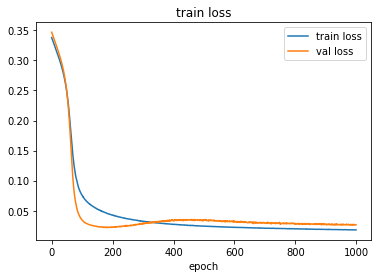

In [153]:
plt.title("train loss")
plt.plot( history.history["loss"] , label='train loss')
plt.plot( history.history["val_loss"], label='val loss' )
plt.legend()

plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

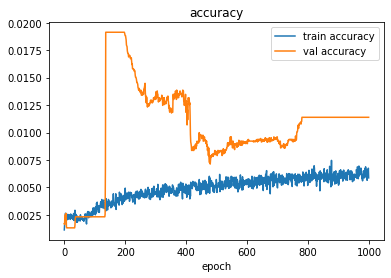

In [154]:
plt.title("accuracy")
plt.plot( history.history["accuracy"] , label='train accuracy')
plt.plot( history.history["val_accuracy"], label='val accuracy' )
plt.legend()

plt.xlabel("epoch")

In [49]:
y_flat

array([3, 3, 2, 1, 2, 3, 3, 3, 0, 2, 4, 3, 2, 3, 2, 2, 1, 0, 2, 1, 3, 4,
       2, 3, 0, 2, 3, 4, 3, 4, 3, 3, 4, 4, 3, 2, 2, 3, 1, 4, 3, 2, 3, 2,
       3, 3, 2, 3, 3, 3, 1, 3, 2, 3, 1, 2, 3, 1, 1, 3, 4, 2, 3, 3, 2, 1,
       2, 1, 0, 1, 3, 3, 1, 1, 4, 3, 3, 0, 4, 0, 4, 3, 3, 3, 3, 1, 4, 3,
       3, 1, 3, 2, 2, 2, 1, 1, 0, 3, 2, 3, 2, 4, 1, 4, 1, 2, 3, 3, 4, 2,
       2, 2, 2, 3, 1, 3, 3, 2, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 2, 1, 2, 3,
       3, 2, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1,
       3, 1, 1, 1, 3, 3, 1, 4, 1, 2, 1, 2, 4, 1, 4, 2, 3, 3, 2, 2, 0, 3,
       3, 4, 0, 3, 3, 3, 1, 3, 3, 2, 3, 3, 1, 1, 2, 3, 3, 2, 1, 2, 3, 1,
       2, 3, 3, 3, 2, 1, 0, 0, 1, 3, 0, 2, 2, 2, 1, 2, 2, 4, 1, 2, 3, 1,
       1, 2, 2, 3, 3, 3, 2, 1, 2, 2, 1, 4, 4, 3, 2, 3, 4, 2, 2, 4, 2, 2,
       0, 1, 2, 2, 0, 3, 4, 1, 3, 0, 1, 3, 3, 1, 3, 3, 4, 3, 2, 3, 1, 3,
       1, 2, 1, 0, 2, 1, 2, 2, 1, 3, 4, 1, 3, 1, 0, 0, 2, 3, 3, 1, 1, 1,
       4, 2, 3, 2, 2, 3, 3, 4, 4, 3, 2, 2, 1, 2, 1,

In [53]:
classes[y_flat[10]]

'Skateboard'

In [281]:
df.reset_index(inplace=True)

In [201]:
n_frames = m.ceil(config.step / config.nfft)

In [408]:
# For plotting examples of each class
mels = {}
mels = defaultdict(list)
n_mels = 60
n_fft = 512
for c in tqdm(classes):
    examples = df[df.labels == c]
    for wav_file in examples['fname'][:10]:
        signal, rate = librosa.load('audio/train/'+wav_file, sr=44100)
        melspec = librosa.feature.melspectrogram(signal, rate, n_mels=n_mels,
                                                n_fft = n_fft)
        melspec = librosa.power_to_db(melspec)
#         melspec = np.log(melspec + np.exp(-6))
        mels[c].append((wav_file, melspec))


In [411]:
config.n_mels

60

In [360]:
### now there are spectograms for every example, organized by class

In [361]:
len(mels['Bus'])

10

In [363]:
mels['Bus'][0]

('f1f0ac34.wav',
 array([[ -0.75787574,   3.902041  ,  -1.5810695 , ...,   4.3148384 ,
          -0.07728985,   3.6111476 ],
        [  8.180464  ,   2.7069185 ,   8.962543  , ...,   5.352805  ,
           5.7921224 ,   3.381433  ],
        [  7.6877446 ,   2.076645  ,   7.534953  , ...,   2.7562914 ,
           7.958968  ,   6.6827292 ],
        ...,
        [-41.553246  , -40.461197  , -42.01313   , ..., -40.45757   ,
         -41.561707  , -41.49355   ],
        [-44.17877   , -42.62635   , -41.779064  , ..., -40.45805   ,
         -40.666573  , -42.631584  ],
        [-48.323246  , -47.149754  , -45.416126  , ..., -45.10359   ,
         -47.56519   , -47.69068   ]], dtype=float32))

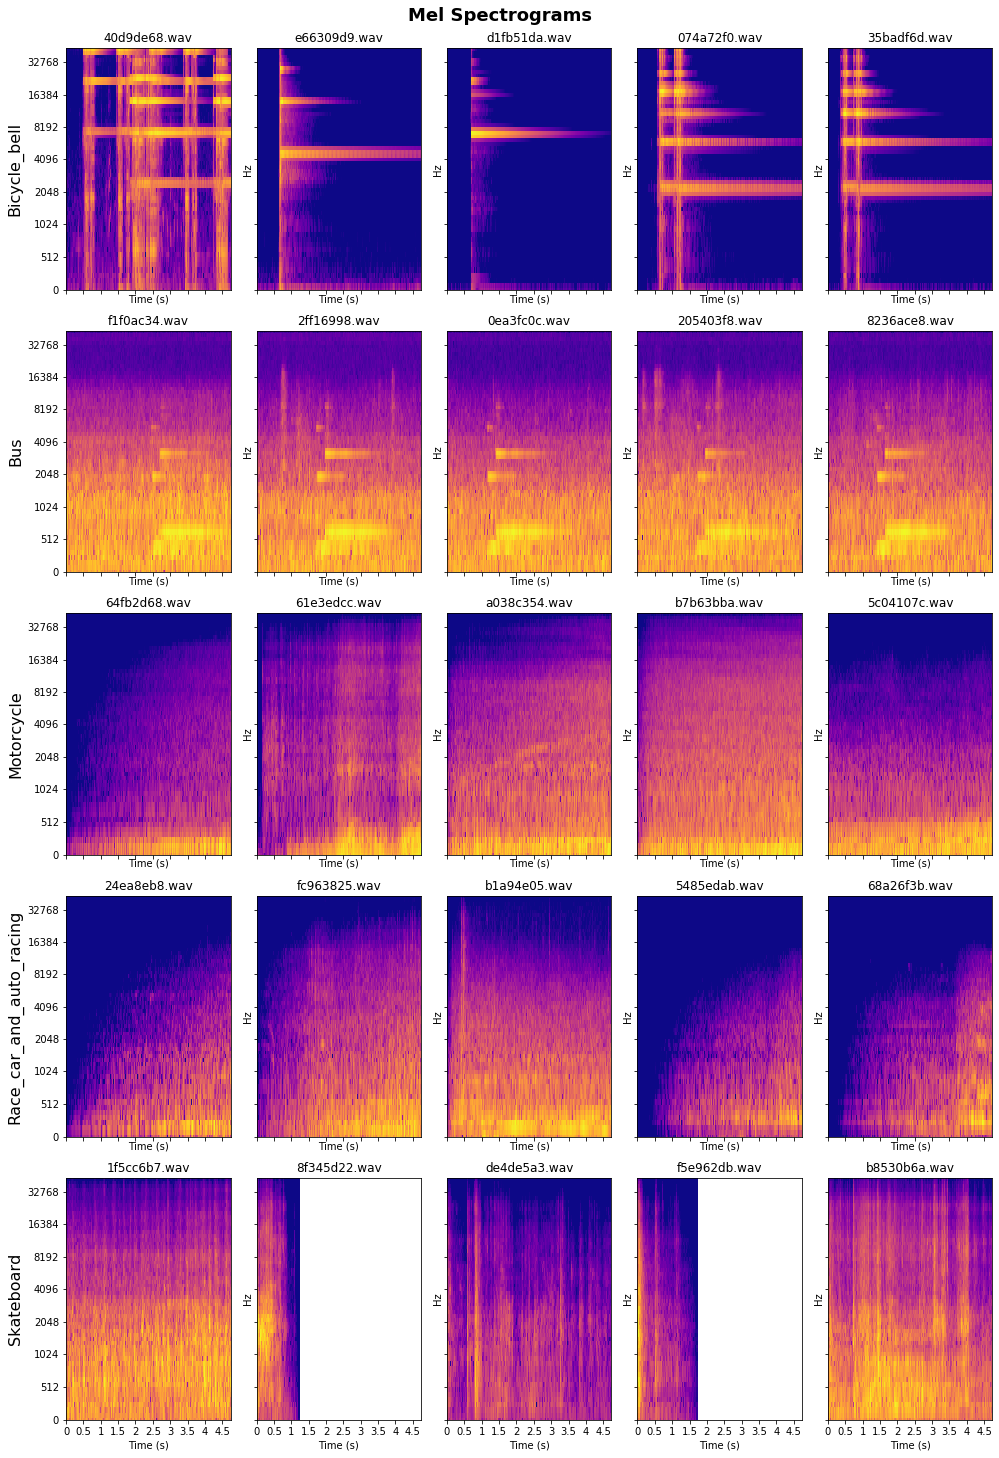

In [426]:
fig, axs = plt.subplots(5, 5, figsize=(14, 20), sharex=True, sharey=True)
fig.suptitle('Mel Spectrograms', y=1.01, fontsize=18, fontweight='bold')

start_idx = 2
end_idx = m.ceil(config.step / config.nfft *20)
for i, (c, mel_list) in enumerate(mels.items()):
#     axs[i,0].set_ylabel(c, fontsize=16)    
    for j, tup in enumerate(mel_list[:5]):
        slice_mel = tup[1][:, start_idx:end_idx]
        librosa.display.specshow(slice_mel, x_axis='s', y_axis='mel',
                                    fmax=44100, ax=axs[i,j], cmap='plasma')

        axs[i,j].set_title(tup[0])
    axs[i,0].set_ylabel(c, fontsize=16) 

plt.tight_layout()
plt.savefig('img/mels_class_examples.png', dpi=256, bbox='tight')

^^^ y axis is the mel filter, x axis is time
There are some very similar looking images, what is going on here?

In [ ]:
librosa.displau

In [386]:
for c, mel_list in mels.items(): 
    print(c)
    for tup in mel_list[:5]:
        print(tup[0])
    print('\n')

Bicycle_bell
40d9de68.wav
e66309d9.wav
d1fb51da.wav
074a72f0.wav
35badf6d.wav


Bus
f1f0ac34.wav
2ff16998.wav
0ea3fc0c.wav
205403f8.wav
8236ace8.wav


Motorcycle
64fb2d68.wav
61e3edcc.wav
a038c354.wav
b7b63bba.wav
5c04107c.wav


Race_car_and_auto_racing
24ea8eb8.wav
fc963825.wav
b1a94e05.wav
5485edab.wav
68a26f3b.wav


Skateboard
1f5cc6b7.wav
8f345d22.wav
de4de5a3.wav
f5e962db.wav
b8530b6a.wav




### Bicycle bells
It seems like these recordings are actually different, and some of them may be the same physical bell recorded repeatedly, which is actually probably helpful, as it's if data augmentation was already performed. That being said, there are very few examples of each class in this dataset.

In [382]:
Audio(filename='audio/train/40d9de68.wav')

In [380]:
Audio(filename='audio/train/d1fb51da.wav')

In [381]:
Audio(filename='audio/train/e66309d9.wav')

In [379]:
Audio(filename='audio/train/35badf6d.wav')

In [378]:
Audio(filename='audio/train/074a72f0.wav')

### Buses 
f1f0ac34.wav,
2ff16998.wav,
0ea3fc0c.wav,
205403f8.wav,
8236ace8.wav
These seem to be of the same bus, but different recordings. The repeated marks on these files' spectrograms are from an chime that sounds inside the bus before an announcement is made. This is slightly annoying since the chime has nothing to do with the sound of the actual bus.

In [393]:
Audio(filename='audio/train/f1f0ac34.wav')

In [394]:
Audio(filename='audio/train/2ff16998.wav')

In [395]:
Audio(filename='audio/train/0ea3fc0c.wav')

In [396]:
Audio(filename='audio/train/205403f8.wav')

In [397]:
Audio(filename='audio/train/8236ace8.wav')

In [ ]:
####

In [398]:
config.nfft

512

In [399]:
n_frames

13

In [ ]:
plt.imshow(img1, aspect='auto')

In [202]:
signal.shape

(10698,)

ValueError: Error when checking input: expected dense_46_input to have shape (780,) but got array with shape (248,)

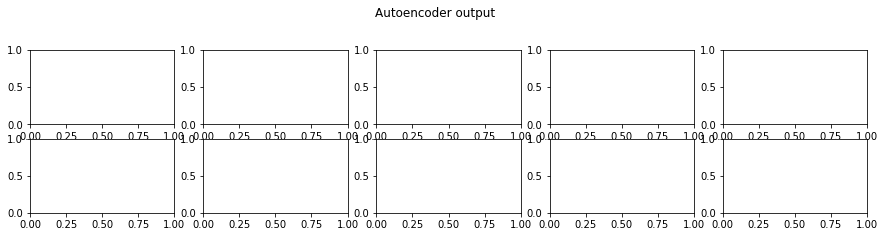

In [410]:
# im_i=15
n_frames = m.ceil(config.step / config.nfft) #number of frames the autoencoder expects
fig, axs = plt.subplots(2,5, figsize=(15,3))
fig.suptitle('Autoencoder output', y=1.08)
i =0
for c, mel_list in mels.items():
    og_img = mel_list[0][1][:n_frames][:, start_idx:end_idx]
    ae_img = aemodel.predict(og_img.reshape(len(og_img), -1))
    axs[0][i].set_title(c)
    axs[0][i].imshow(og_img, aspect='auto')
    axs[1][i].imshow(ae_img, aspect='auto')
    i +=1
plt.tight_layout()


In [300]:

# from auto_encoder.tensorflow import AutoEncoder 

ModuleNotFoundError: No module named 'auto_encoder'

In [266]:
# checking thresholds. first, curated train
def envelope(y, rate, threshold):
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/5), min_periods=1, center=True).mean()
    mask = y_mean > threshold
    return mask

In [267]:
def plot_signals(signals):
    fig, axs = plt.subplots(2, 4, sharex=False,
                            sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    idx = 0
    for i in range(2):
        for j in range(4):
            axs[i,j].set_title(list(signals.keys())[idx])
            axs[i,j].plot(list(signals.values())[idx])
            axs[i,j].get_xaxis().set_visible(False)
            axs[i,j].get_yaxis().set_visible(False)
            idx += 1

In [268]:
df = pd.read_csv('data/train/roadsound_labels.csv')
df.set_index('fname', inplace=True)


In [269]:
#single file:
df.iloc[101,1]

'Race_car_and_auto_racing'

In [270]:
f = 'fddda41d.wav'

In [271]:
def plot_thresh_effect(f):
    signal, rate = librosa.load('audio/train/'+f, sr=16000)
    thresholds = [0.005, 0.01, 0.05, 0.1, 0.2]
    masked = []
    for thresh in thresholds:
        mask = envelope(signal, rate, thresh)
        masked.append(signal[mask])

    fig, axs = plt.subplots(6, figsize=(16, 16), sharex=True, sharey=True)
    fig.suptitle('Various noise thresholds')
    axs[0].plot(signal, label='original')
    axs[0].legend()

    for i in range(5):
        axs[i+1].plot(masked[i],
                    label='signal threshold: '+str(thresholds[i]))
        axs[i+1].legend(loc='upper right')
        Audio(data=masked[i], rate=rate)


Race car 1


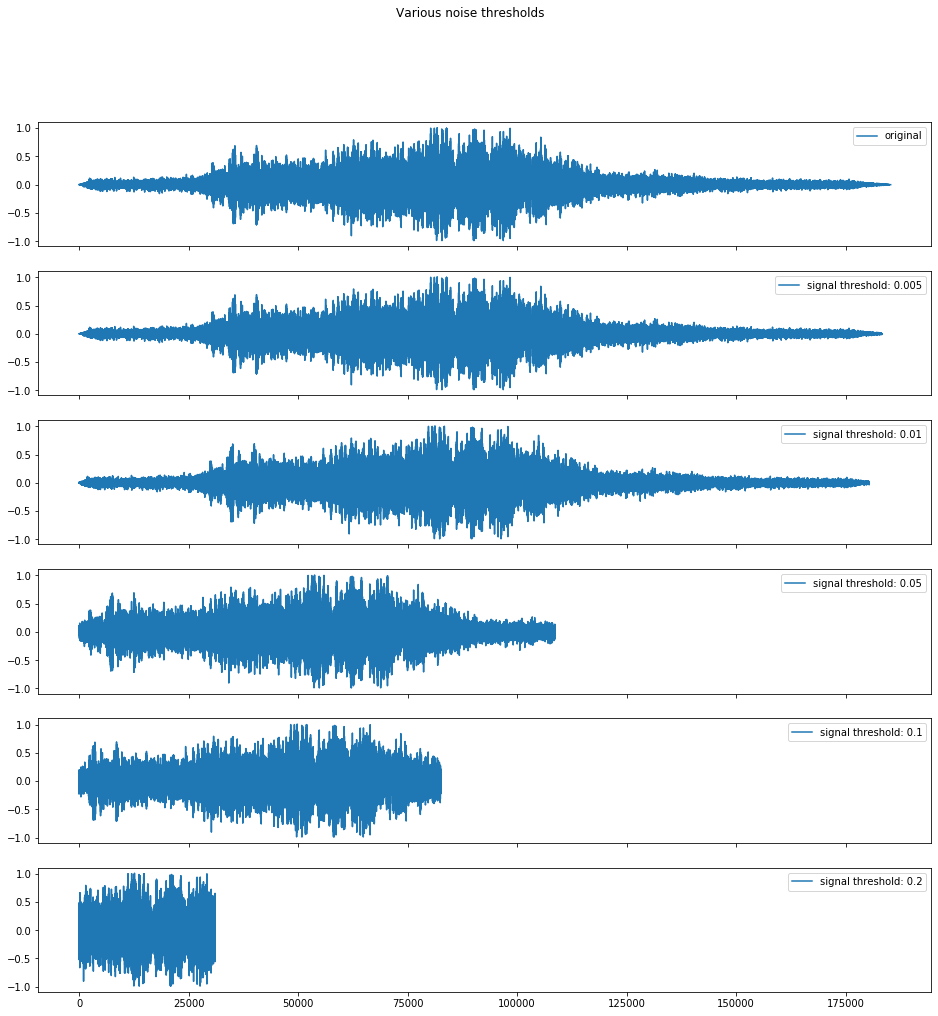

In [272]:
print('Race car 1')
plot_thresh_effect('fddda41d.wav')

In [273]:
Audio(data=signal, rate=rate)